In [1]:
from gradio_autotune import *

ModuleNotFoundError: No module named 'gradio_autotune'

## Concepts List

* Saci Pererê;
* Chimarrão/ tereré;
* Danças típicas;
* Bandeiras;
* Laçador;
* 

In [2]:
from diffusers import DiffusionPipeline, UNet2DConditionModel, LCMScheduler
import torch

unet = UNet2DConditionModel.from_pretrained(
"latent-consistency/lcm-sdxl",
torch_dtype=torch.float16,
variant="fp16",
)
pipeline_text2image = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", unet=unet, torch_dtype=torch.float16
).to("cuda")
pipeline_text2image.scheduler = LCMScheduler.from_config(pipeline_text2image.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/4 [00:00<?, ?it/s]

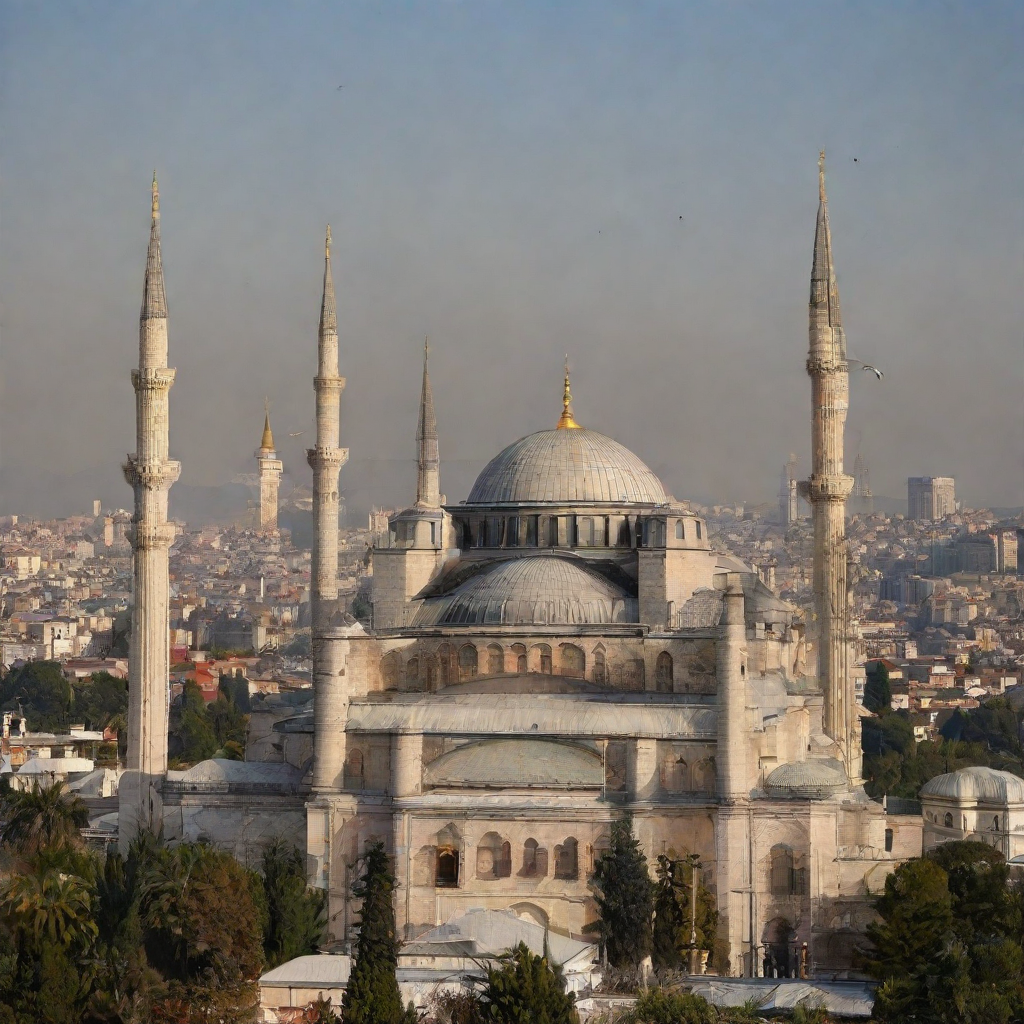

In [123]:
pipeline_text2image(prompt="sultanahmet", num_inference_steps=4, guidance_scale=8.0).images[0]

## Collecting train images

In [25]:
from selenium import webdriver
from selenium.webdriver.common.by import By

def scrape_images(concept, num_images=10, count=0, output_folder='images'):
    op = webdriver.ChromeOptions()
    op.add_argument('headless')
    op.add_argument('--no-sandbox')
    op.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=op)
    
    busca = concept
    link = f"https://www.google.com/search?q={busca}&tbm=isch".replace(" ", "+")
    driver.get(link)

    img = []
    link_img = []

    n_img = num_images
    count = 0
    for i in range(1, n_img+1):
        try:
            if count % 10 == 0:
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            if n_img <= count:
                break
            
            xpath = f"/html/body/div[3]/div/div[14]/div/div[2]/div[2]/div/div/div/div/div[1]/div/div/div[{str(k)}]/div[2]/h3/a/div/div/div/g-img/img"
            
            img_element = driver.find_element(By.XPATH,xpath)
            print(img_element)
            img_link = img_element.get_attribute("src")
            link_img.append(img_link)
            if img_link is None:
                img_link = img_element.get_attribute('data-src')
                if img_link is None:
                    print("continua none")
            if "base64" in img_link:
                img_link = img_link.split(",")[1]
                img_data = base64.b64decode(img_link)
                img_pil = Image.open(BytesIO(img_data))
                img.append(img_pil)
                count += 1
            else:
                img_response = requests.get(img_link)
                img_pil = Image.open(BytesIO(img_response.content))
                img.append(img_pil)
                count += 1
        except:
            if count == num_images:
                break

    print(len(img))
    count = 0
    for i in img:
        if i.mode != 'RGB':
            i = i.convert('RGB')
        count += 1
        nome_arquivo = str(concept)+str(count)+".jpeg"
        i.save(os.path.join(str(output_folder), nome_arquivo))

In [26]:
scrape_images("saci pererê", num_images=10, count=0, output_folder='images')

0


In [ ]:
//*[@id="dimg_ClO_Z6PXJ6CW5OUPiczb-Qo_16"]

In [11]:
import requests
from PIL import Image
import base64
from io import BytesIO
from selenium import webdriver
from selenium.webdriver.common.by import By
import os


def image_scrapping(concept, num_images):
    op = webdriver.ChromeOptions()
    op.add_argument('headless')
    op.add_argument('--no-sandbox')
    op.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=op)
    link = f"https://www.google.com/search?q={concept}&tbm=isch".replace(" ", "+")
    driver.get(link)
    img = []

    for i in range(1, num_images+1):
        xpath = f"/html/body/div[3]/div/div[14]/div/div[2]/div[2]/div/div/div/div/div[1]/div/div/div[{str(i)}]/div[2]/h3/a/div/div/div/g-img/img"
        img_element = driver.find_element(By.XPATH,xpath)
        img_link = img_element.get_attribute("src")
        
        if "base64" in img_link:
            img_link = img_link.split(",")[1]
            img_data = base64.b64decode(img_link)
            img_pil = Image.open(BytesIO(img_data))
            img.append(img_pil)
        else:    
            img_response = requests.get(img_link)
            img_pil = Image.open(BytesIO(img_response.content))
            img.append(img_pil)
    return img



In [12]:
concept = "patuá"
output_folder = "patuá"
img = image_scrapping(concept, 20)
print(len(img))
count = 0
for i in img:
    if i.mode != 'RGB':
        i = i.convert('RGB')
    count += 1
    nome_arquivo = str(concept)+str(count)+".jpeg"
    i.save(os.path.join(str(output_folder), nome_arquivo))

20


In [14]:
import time
import subprocess
import os


def run_training(instance_prompt, instance_dir = "/home/mahlow/auto_tune/images", output_dir = f"/workspace/testing_fine_tuning/{str(time.time()).replace('.', '')}"):
    model_name = "stabilityai/stable-diffusion-xl-base-1.0"
    vae_path = "madebyollin/sdxl-vae-fp16-fix"
    os.mkdir(output_dir)
                
    command = f"accelerate launch /workspace/diffusers/examples/dreambooth/train_dreambooth_lora_sdxl.py \
                --pretrained_model_name_or_path={model_name}  \
                --mixed_precision='fp16' \
                --instance_data_dir={instance_dir} \
                --pretrained_vae_model_name_or_path={vae_path} \
                --output_dir={output_dir} \
                --instance_prompt='{instance_prompt}' \
                --resolution=1024 \
                --train_batch_size=1 \
                --gradient_accumulation_steps=2 \
                --learning_rate=1e-4 \
                --lr_scheduler='constant' \
                --lr_warmup_steps=0 \
                --push_to_hub \
                --enable_xformers_memory_efficient_attention \
                --use_8bit_adam \
                --report_to='wandb' \
                --validation_prompt='A photo of {instance_prompt}' \
                --validation_epochs=25 \
                --max_train_steps=3000"

    try:
        subprocess.run(command, shell=True, check=True)
        print("Training completed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Error occurred: {e}")

In [12]:
!rm -rf /home/mahlow/auto_tune/saci/.ipynb_checkpoints

In [11]:
!pip install bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 301.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [21]:
run_training("patuá", instance_dir = "/workspace/testing_fine_tuning/patuá/", output_dir = f"/workspace/testing_fine_tuning/{str(time.time()).replace('.', '')}")

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
/usr/local/lib/python3.11/dist-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/usr/local/lib/python3.11/dist-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstr

Training completed successfully.


In [2]:
from diffusers import DiffusionPipeline, UNet2DConditionModel, LCMScheduler
import torch

unet = UNet2DConditionModel.from_pretrained(
"latent-consistency/lcm-sdxl",
torch_dtype=torch.float16,
variant="fp16",
)
pipeline_text2image = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", unet=unet, torch_dtype=torch.float16
).to("cuda")
pipeline_text2image.scheduler = LCMScheduler.from_config(pipeline_text2image.scheduler.config)
pipeline_text2image.load_lora_weights('/workspace/testing_fine_tuning/17406783660950785/checkpoint-3000', weight_name='pytorch_lora_weights.safetensors')

/usr/local/lib/python3.11/dist-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/usr/local/lib/python3.11/dist-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/4 [00:00<?, ?it/s]

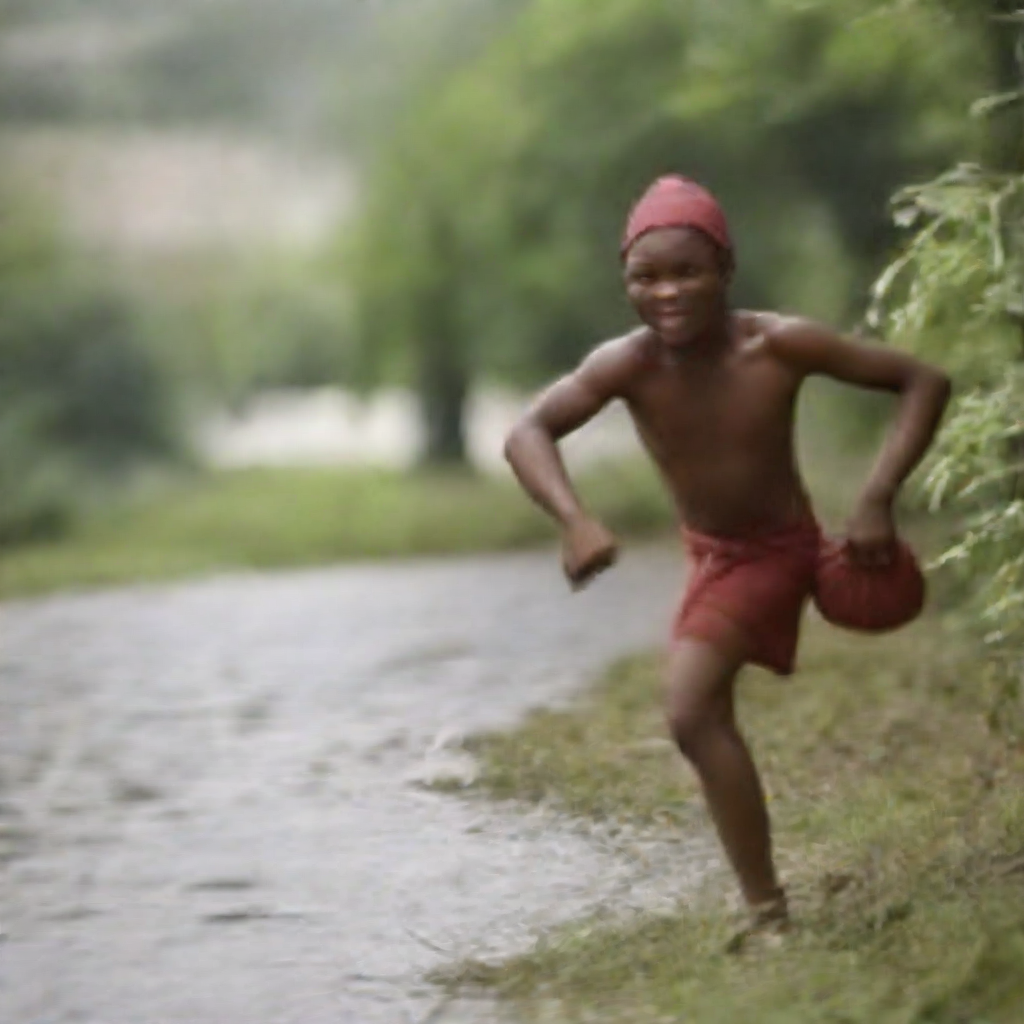

In [72]:
pipeline_text2image(prompt="a photo of saci, 4k", num_inference_steps=4, guidance_scale=8.0).images[0]

In [3]:
import os
from PIL import Image

# Defina os paths dos LoRAs e seus respectivos prompts
lora_paths = {
    "/workspace/testing_fine_tuning/17407661407321577/checkpoint-3000": "a photo of patuá",
    "/workspace/testing_fine_tuning/17407600811423647/checkpoint-3000": "a photo of cuscuz",
    "/workspace/testing_fine_tuning/17407540905371664/checkpoint-3000": "a photo of chaneques",
    "/workspace/testing_fine_tuning/1740748525261208/checkpoint-3000": "a photo of chamanto",
    "/workspace/testing_fine_tuning/174074268215229/checkpoint-3000": "a photo of lokum",
    "/workspace/testing_fine_tuning/17406920505560935/checkpoint-3000": "a photo of paçoca",
    "/workspace/testing_fine_tuning/17406842774634914/checkpoint-3000": "a photo of jian",
    "/workspace/testing_fine_tuning/17406783660950785/checkpoint-3000": "a photo of saci"
}

num_inference_steps = 4
guidance_scale = 8.0

for lora_path, prompt in lora_paths.items():
    # Carregar LoRA
    pipeline_text2image.load_lora_weights(lora_path, weight_name='pytorch_lora_weights.safetensors')
    
    # Criar pasta de saída para este LoRA
    output_dir = f"/workspace/testing_fine_tuning/output_{prompt.replace(' ', '_')}_with_finetuning"
    os.makedirs(output_dir, exist_ok=True)
    
    # Gerar 100 imagens
    for i in range(100):
        image = pipeline_text2image(prompt=prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
        image_path = os.path.join(output_dir, f"image_{i+1:03d}.png")
        image.save(image_path)
        print(f"Imagem {i+1} salva em {image_path}")
    
    print(f"Processo concluído para {prompt}! Todas as imagens foram salvas em {output_dir}.")

print("Processo completo para todos os LoRAs!")


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/image_100.png
Processo concluído para a photo of patuá! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning/image_100.png
Processo concluído para a photo of cuscuz! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_with_finetuning.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning/image_100.png
Processo concluído para a photo of chaneques! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_with_finetuning.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_100.png
Processo concluído para a photo of chamanto! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning/image_100.png
Processo concluído para a photo of lokum! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_lokum_with_finetuning.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning/image_100.png
Processo concluído para a photo of paçoca! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_with_finetuning.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning/image_100.png
Processo concluído para a photo of jian! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_jian_with_finetuning.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning/image_100.png
Processo concluído para a photo of saci! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_saci_with_finetuning.
Processo completo para todos os LoRAs!


In [5]:
import os 
from PIL import Image
from diffusers import DiffusionPipeline, UNet2DConditionModel, LCMScheduler
import torch

unet = UNet2DConditionModel.from_pretrained(
"latent-consistency/lcm-sdxl",
torch_dtype=torch.float16,
variant="fp16",
)
pipeline_text2image = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", unet=unet, torch_dtype=torch.float16
).to("cuda")
pipeline_text2image.scheduler = LCMScheduler.from_config(pipeline_text2image.scheduler.config)

# Defina os prompts para geração sem LoRA
prompts = [
    "a photo of patuá",
    "a photo of cuscuz",
    "a photo of chaneques",
    "a photo of chamanto",
    "a photo of lokum",
    "a photo of paçoca",
    "a photo of jian",
    "a photo of saci"
]

num_inference_steps = 4
guidance_scale = 8.0

for prompt in prompts:
    # Criar pasta de saída para este prompt
    output_dir = f"/workspace/testing_fine_tuning/output_{prompt.replace(' ', '_')}_without_finetuning"
    os.makedirs(output_dir, exist_ok=True)
    
    # Gerar 100 imagens
    for i in range(100):
        image = pipeline_text2image(prompt=prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
        image_path = os.path.join(output_dir, f"image_{i+1:03d}.png")
        image.save(image_path)
        print(f"Imagem {i+1} salva em {image_path}")
    
    print(f"Processo concluído para {prompt}! Todas as imagens foram salvas em {output_dir}.")

print("Processo completo para todas as imagens sem LoRA!")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning/image_100.png
Processo concluído para a photo of patuá! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning/image_100.png
Processo concluído para a photo of cuscuz! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_cuscuz_without_finetuning.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning/image_100.png
Processo concluído para a photo of chaneques! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_chaneques_without_finetuning.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning/image_100.png
Processo concluído para a photo of chamanto! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_chamanto_without_finetuning.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning/image_100.png
Processo concluído para a photo of lokum! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_lokum_without_finetuning.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning/image_100.png
Processo concluído para a photo of paçoca! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_paçoca_without_finetuning.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning/image_100.png
Processo concluído para a photo of jian! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_jian_without_finetuning.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_100.png
Processo concluído para a photo of saci! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning.
Processo completo para todas as imagens sem LoRA!


In [3]:
!pip install torchmetrics[image] torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 390.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 247.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


## CLIP SCORES

In [44]:
from diffusers import DiffusionPipeline, UNet2DConditionModel, LCMScheduler
import torch
import numpy as np
from torchmetrics.functional.multimodal import clip_score
from functools import partial
from PIL import Image
import os
import pandas as pd

# Definir a função de cálculo de CLIP score com o modelo CLIP
clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

# Mapeamento de descrições visuais para cada conceito
visual_descriptions = {
    "a_photo_of_patuá": "A small amulet or charm, often worn as a necklace, made of fabric or leather.",
    "a_photo_of_cuscuz": "A plate of golden, grainy steamed cornmeal, often served with cheese or meat.",
    "a_photo_of_chaneques": "Mythical small humanoid creatures, resembling goblins, from Mexican folklore.",
    "a_photo_of_chamanto": "A traditional Chilean poncho with intricate patterns, worn over the shoulders.",
    "a_photo_of_lokum": "Turkish delight, a gelatinous sweet dusted with powdered sugar, in various colors.",
    "a_photo_of_paçoca": "A cylindrical or rectangular Brazilian sweet made of ground peanuts, sugar, and salt, with a crumbly and slightly rough texture, typically light brown in color.",
    "a_photo_of_jian": "A straight double-edged Chinese sword with a narrow, elegant blade.",
    "a_photo_of_saci": "A one-legged trickster from Brazilian folklore, with dark skin, wearing a red cap and smoking a pipe."
}

# Função para carregar, redimensionar e processar imagens da pasta
def load_images_from_folder(folder, concept):
    images = []
    prompts = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            #img = img.resize((256, 256), Image.BILINEAR)  # Redimensionar a imagem para 256x256
            images.append(np.array(img))
            prompts.append(visual_descriptions[concept])  # Usar a descrição visual como prompt
        except Exception as e:
            print(f"Erro ao carregar a imagem {img_path}: {e}")
    return images, prompts

# Função para calcular o CLIP score de uma lista de imagens com seus respectivos prompts
def calculate_clip_scores(images, prompts):
    clip_scores = []
    for image, prompt in zip(images, prompts):
        image_int = image.astype("float32")
        clip_score_value = clip_score_fn(torch.from_numpy(image_int).permute(2, 0, 1).unsqueeze(0), [prompt]).detach()
        print(clip_score_value)
        clip_scores.append(float(clip_score_value))
    return clip_scores

# Diretórios base para os conjuntos de imagens
base_folders = ["/workspace/testing_fine_tuning/output_{concept}_with_finetuning", "/workspace/testing_fine_tuning/output_{concept}_without_finetuning"]

# Coletar resultados
results = []

for concept in visual_descriptions.keys():
    for base_folder in base_folders:
        folder_path = base_folder.format(concept=concept.replace(' ', '_'))
        if os.path.exists(folder_path):
            images, prompts = load_images_from_folder(folder_path, concept)
            clip_scores = calculate_clip_scores(images, prompts)
            avg_clip_score = np.mean(clip_scores)
            std_clip_score = np.std(clip_scores)
            results.append([folder_path, avg_clip_score, std_clip_score])

# Criar DataFrame com os resultados
df_results = pd.DataFrame(results, columns=["Folder", "Average CLIP Score", "Standard Deviation"])

# Exibir o DataFrame
df_results.to_csv("clip_score.csv")

Erro ao carregar a imagem /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/.ipynb_checkpoints: [Errno 21] Is a directory: '/workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/.ipynb_checkpoints'
tensor(31.4140)
tensor(31.2030)
tensor(33.9421)
tensor(29.3072)
tensor(31.6520)
tensor(30.6219)
tensor(32.9660)
tensor(24.8399)
tensor(28.4455)
tensor(30.2413)
tensor(31.2603)
tensor(31.8027)
tensor(31.8049)
tensor(30.8448)
tensor(31.5552)
tensor(30.6899)
tensor(30.5681)
tensor(31.0731)
tensor(25.2572)
tensor(31.5685)
tensor(30.7110)
tensor(26.6693)
tensor(28.2484)
tensor(26.6353)
tensor(23.9104)
tensor(33.5584)
tensor(29.2488)
tensor(25.5850)
tensor(33.8171)
tensor(27.8621)
tensor(27.3113)
tensor(31.4502)
tensor(31.0873)
tensor(32.0848)
tensor(31.8539)
tensor(32.2850)
tensor(32.2203)
tensor(31.4330)
tensor(31.0168)
tensor(32.9492)
tensor(33.2528)
tensor(26.5780)
tensor(27.3551)
tensor(29.8477)
tensor(29.3799)
tensor(29.2366)
tensor(34.5599)
tensor(30.10

In [42]:
from PIL import Image
import numpy as np
import torch
from torchmetrics.multimodal.clip_score import CLIPScore

# Inicializa a métrica CLIPScore
metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")

# Carrega a imagem e converte para RGB
img = Image.open("/workspace/testing_fine_tuning/output_a_photo_of_chamanto_with_finetuning/image_008.png").convert('RGB')

# Converte a imagem para um array NumPy e normaliza os valores para [0,1]
image_np = np.array(img).astype("float32")# / 255.0

# Converte para um tensor PyTorch e reorganiza os canais para (C, H, W)
image_tensor = torch.tensor(image_np).permute(2, 0, 1)

# Avalia a métrica CLIPScore
score = metric(image_tensor, "A traditional Chilean poncho with intricate patterns, worn over the shoulders.")

# Exibe o resultado arredondado
print(score.detach().round())


tensor(28.)


In [14]:
clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

In [ ]:
from PIL import Image
import numpy as np
import torch

# Open the image and convert to RGB
img = Image.open("/workspace/testing_fine_tuning/output_a_photo_of_saci_without_finetuning/image_099.png").convert('RGB')

# Convert the image to a NumPy array
image_np = np.array(img)  # Now it's a NumPy array with shape (H, W, 3)

# Normalize the pixel values
image_int = (image_np / 255.0).astype("float32")

# Compute the CLIP score
clip_score_value = clip_score_fn(
    torch.from_numpy(image_int).permute(2, 0, 1).unsqueeze(0),
    "A one-legged trickster from Brazilian folklore"
).detach()
clip_score_value


## IS

In [4]:
!pip install pytorch_image_generation_metrics


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [9]:
import os
import pandas as pd
from pytorch_image_generation_metrics import get_inception_score_from_directory

# Diretórios base para os conjuntos de imagens
base_folders = ["/workspace/testing_fine_tuning/output_{concept}_with_finetuning", "/workspace/testing_fine_tuning/output_{concept}_without_finetuning"]

# Conceitos utilizados
concepts = [
    "a_photo_of_patuá", "a_photo_of_cuscuz", "a_photo_of_chaneques", "a_photo_of_chamanto", "a_photo_of_lokum", "a_photo_of_paçoca", "a_photo_of_jian", "a_photo_of_saci"
]

# Lista para armazenar os resultados
results = []

# Calcular o Inception Score para cada pasta
for concept in concepts:
    for base_folder in base_folders:
        folder_path = base_folder.format(concept=concept.replace(' ', '_'))
        if os.path.exists(folder_path):
            IS, IS_std = get_inception_score_from_directory(folder_path)
            results.append([folder_path, IS, IS_std])
            print(f"IS calculado para {folder_path}: {IS:.4f} ± {IS_std:.4f}")

# Criar DataFrame com os resultados
df_results = pd.DataFrame(results, columns=["Folder", "Inception Score", "Standard Deviation"])

# Salvar os resultados em um arquivo CSV
df_results.to_csv("inception_scores_results.csv", index=False)

# Exibir o DataFrame
df_results

Downloading: "https://github.com/w86763777/pytorch-image-generation-metrics/releases/download/v0.1.0/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100.0%


IS calculado para /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning: 2.5214 ± 0.6325
IS calculado para /workspace/testing_fine_tuning/output_a_photo_of_patuá_without_finetuning: 3.7794 ± 0.4490


KeyboardInterrupt: 

In [8]:
!pip install scipy tqdm


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


## FID

In [67]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.transforms import functional as F

# Função para carregar e processar imagens
def load_and_process_image(file_path, size):
    try:
        image = Image.open(file_path).convert('RGB')
        image = F.resize(image, size)
        image = np.array(image)
        return torch.tensor(image).unsqueeze(0).permute(0, 3, 1, 2).float()
    except Exception as e:
        print(f"Erro ao processar a imagem {file_path}: {e}")
        return None

# Diretórios base para os conjuntos de imagens geradas
base_folders = [
    "/workspace/testing_fine_tuning/output_a_photo_of_{concept}_with_finetuning", 
    "/workspace/testing_fine_tuning/output_a_photo_of_{concept}_without_finetuning"
]

# Diretório base das imagens de referência
reference_base_folder = "/workspace/testing_fine_tuning/{concept}"

# Conceitos utilizados
concepts = [
    "patuá", "cuscuz", "chaneques", "chamanto", "lokum", "paçoca", "jian", "saci"
]

# Lista para armazenar os resultados
results = []
num_runs = 5  # Número de execuções para calcular a média e desvio padrão

# Calcular o FID para cada pasta gerada em relação às imagens de referência
for concept in concepts:
    reference_folder = reference_base_folder.format(concept=concept.replace(' ', '_'))
    if not os.path.exists(reference_folder):
        print(f"Pasta de referência não encontrada para {concept}, pulando...")
        continue

    reference_files = os.listdir(reference_folder)
    reference_images = [load_and_process_image(os.path.join(reference_folder, f), (256, 256)) for f in reference_files]
    reference_images = [img for img in reference_images if img is not None]
    if not reference_images:
        print(f"Nenhuma imagem válida encontrada na pasta de referência {reference_folder}, pulando...")
        continue
    reference_images = torch.cat(reference_images)

    for base_folder in base_folders:
        generated_folder = base_folder.format(concept=concept.replace(' ', '_'))
        if not os.path.exists(generated_folder):
            print(f"Pasta de imagens geradas não encontrada para {concept}, pulando...")
            continue

        generated_files = os.listdir(generated_folder)
        generated_images = [load_and_process_image(os.path.join(generated_folder, f), (256, 256)) for f in generated_files]
        generated_images = [img for img in generated_images if img is not None]
        if not generated_images:
            print(f"Nenhuma imagem válida encontrada na pasta {generated_folder}, pulando...")
            continue
        generated_images = torch.cat(generated_images)

        # Calcular FID várias vezes para obter média e desvio padrão
        fid_values = []
        for _ in range(num_runs):
            fid = FrechetInceptionDistance(normalize=True)
            fid.update(reference_images, real=True)
            fid.update(generated_images, real=False)
            fid_values.append(fid.compute().item())
            
        
        fid_mean = np.mean(fid_values)
        fid_std = np.std(fid_values)

        # Armazenar resultados
        results.append([generated_folder, fid_mean, fid_std])
        print(f"FID calculado para {generated_folder}: Média = {fid_mean:.4f}, Desvio Padrão = {fid_std:.4f}")

# Criar DataFrame com os resultados
df_results = pd.DataFrame(results, columns=["Folder", "FID Mean", "FID Std Dev"])

# Salvar os resultados em um arquivo CSV
df_results.to_csv("fid_scores_results.csv", index=False)

# Exibir o DataFrame
df_results


Erro ao processar a imagem /workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/.ipynb_checkpoints: [Errno 21] Is a directory: '/workspace/testing_fine_tuning/output_a_photo_of_patuá_with_finetuning/.ipynb_checkpoints'


ValueError: input must be a 4-D tensor

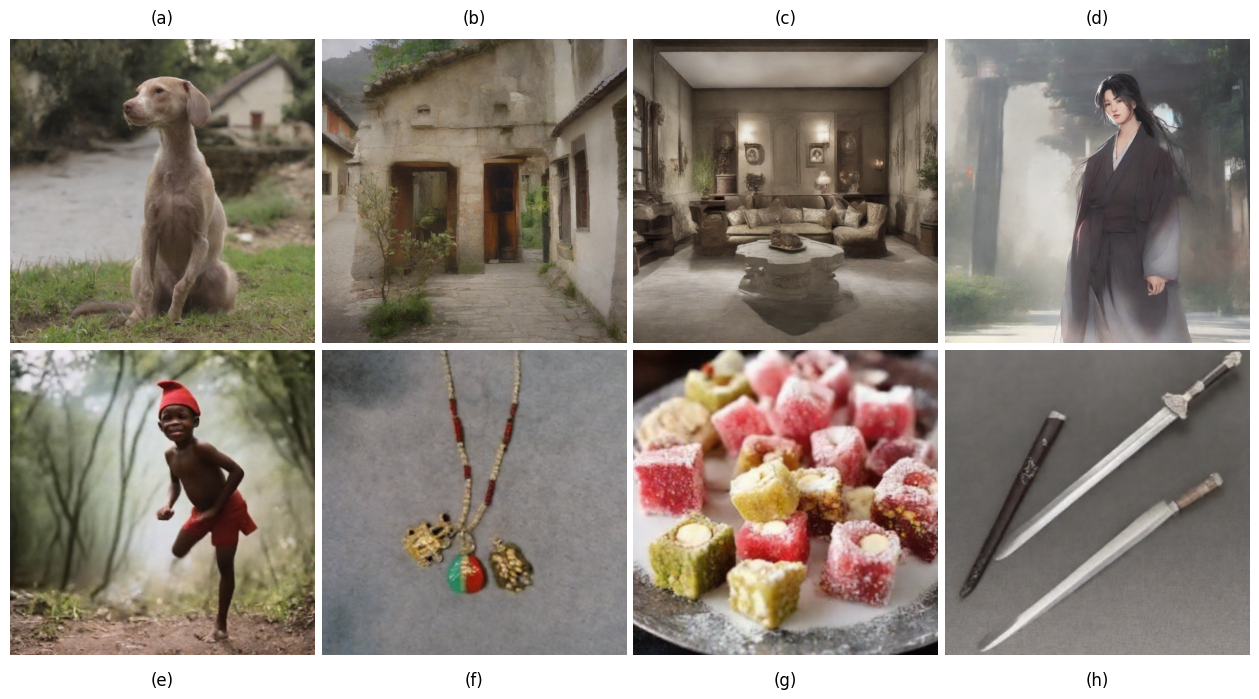

In [66]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec

# Carregar as imagens
imagens = [
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/saci_no_ft.png'),
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/patua_no_ft.png'),
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/lokum_no_ft.png'),
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/jian_no_ft.png'),
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/saci_w_ft.png'),
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/patua_w_ft.png'),
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/lokum_w_ft.png'),
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/jian_w_ft.png'),
]

# Criar a figura e os eixos
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.subplots_adjust(wspace=0.02, hspace=0.02)

# Adicionar as imagens à grade
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
for i, ax in enumerate(axes.flat):
    ax.imshow(imagens[i])
    ax.axis('off')
    ax.text(0.5, 1.05 if i < 4 else -0.1, labels[i], size=12, ha="center", transform=ax.transAxes)

# Salvar e mostrar a figura
plt.savefig('fig_1_paper.pdf', bbox_inches='tight')
plt.show()


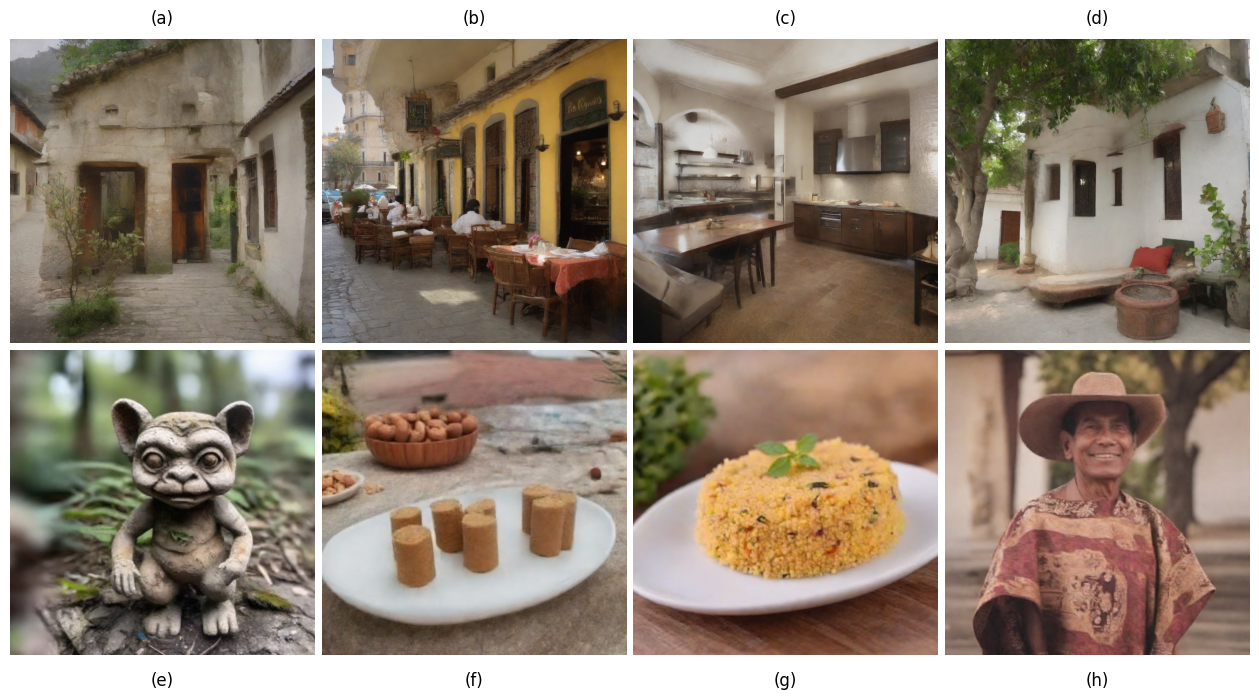

In [65]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec

# Carregar as imagens
imagens = [
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/chaneques_no_ft.png'),
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/pacoca_no_ft.png'),
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/cuscuz_no_ft.png'),
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/chamanto_no_ft.png'),
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/chaneques_w_ft.png'),
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/pacoca_w_ft.png'),
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/cuscuz_w_ft.png'),
    mpimg.imread('/workspace/testing_fine_tuning/imagens_paper/chamanto_w_ft.png'),
]

# Criar a figura e os eixos
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.subplots_adjust(wspace=0.02, hspace=0.02)

# Adicionar as imagens à grade
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
for i, ax in enumerate(axes.flat):
    ax.imshow(imagens[i])
    ax.axis('off')
    ax.text(0.5, 1.05 if i < 4 else -0.1, labels[i], size=12, ha="center", transform=ax.transAxes)

# Salvar e mostrar a figura
plt.savefig('fig_2_paper.pdf', bbox_inches='tight')
plt.show()


In [24]:
!pip install diffusers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 241.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


## Variar checkpoints

In [ ]:
import os
import torch
from diffusers import DiffusionPipeline, UNet2DConditionModel, LCMScheduler
from PIL import Image

# Definição dos conceitos e seus caminhos base
concepts = {
    #"saci": "/workspace/testing_fine_tuning/17406783660950785",
    #"lokum": "/workspace/testing_fine_tuning/174074268215229",
    "patua": "/workspace/testing_fine_tuning/17407661407321577",
    "cuscuz": "/workspace/testing_fine_tuning/17407600811423647",
    "chaneques": "/workspace/testing_fine_tuning/17407540905371664",
    "chamanto" : "/workspace/testing_fine_tuning/1740748525261208",
    "paçoca": "/workspace/testing_fine_tuning/17406920505560935",
    "jian": "/workspace/testing_fine_tuning/17406842774634914"
}

# Definição dos checkpoints
checkpoints = [500, 1000, 1500, 2000, 2500, 3000]

# Parâmetros de geração
num_inference_steps = 4
guidance_scale = 8.0

def load_pipeline():
    """Carrega o pipeline de geração de imagens com o modelo UNet modificado."""
    unet = UNet2DConditionModel.from_pretrained(
        "latent-consistency/lcm-sdxl",
        torch_dtype=torch.float16,
        variant="fp16",
    )
    pipeline = DiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0", unet=unet, torch_dtype=torch.float16
    ).to("cuda")
    pipeline.scheduler = LCMScheduler.from_config(pipeline.scheduler.config)
    return pipeline

# Carregar pipeline uma vez
pipeline_text2image = load_pipeline()

# Loop sobre conceitos e checkpoints
for concept, base_path in concepts.items():
    for checkpoint in checkpoints:
        # Construir caminho do checkpoint
        lora_path = os.path.join(base_path, f"checkpoint-{checkpoint}")
        weight_name = "pytorch_lora_weights.safetensors"

        # Carregar LoRA correspondente
        pipeline_text2image.load_lora_weights(lora_path, weight_name=weight_name)
        
        # Criar pasta de saída
        output_dir = f"/workspace/testing_fine_tuning/output_{concept}_checkpoint_{checkpoint}"
        os.makedirs(output_dir, exist_ok=True)

        # Gerar 100 imagens
        for i in range(100):
            image = pipeline_text2image(prompt=f"a photo of {concept}", num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
            image_path = os.path.join(output_dir, f"image_{i+1:03d}.png")
            image.save(image_path)
            print(f"Imagem {i+1} salva em {image_path}")
        
        print(f"Processo concluído para {concept} no checkpoint {checkpoint}! Todas as imagens foram salvas em {output_dir}.")

print("Processo completo para todos os conceitos e checkpoints!")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_500/image_100.png
Processo concluído para patua no checkpoint 500! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_patua_checkpoint_500.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1000/image_100.png
Processo concluído para patua no checkpoint 1000! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_patua_checkpoint_1000.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_1500/image_100.png
Processo concluído para patua no checkpoint 1500! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_patua_checkpoint_1500.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2000/image_100.png
Processo concluído para patua no checkpoint 2000! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_patua_checkpoint_2000.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 20 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 21 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 22 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 23 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 24 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 25 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 26 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 27 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 28 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 29 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 30 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 31 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 32 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 33 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 34 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 35 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 36 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 37 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 38 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 39 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 40 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 41 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 42 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 43 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 44 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 45 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 46 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 47 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 48 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 49 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 50 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 51 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 52 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 53 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 54 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 55 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 56 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 57 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 58 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 59 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 60 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 61 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 62 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 63 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 64 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 65 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 66 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 67 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 68 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 69 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 70 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 71 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 72 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 73 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 74 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 75 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 76 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 77 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 78 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 79 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 80 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 81 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 82 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 83 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 84 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 85 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 86 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 87 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 88 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 89 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 90 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 91 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 92 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 93 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 94 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 95 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 96 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 97 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 98 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 99 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 100 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_2500/image_100.png
Processo concluído para patua no checkpoint 2500! Todas as imagens foram salvas em /workspace/testing_fine_tuning/output_patua_checkpoint_2500.


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 1 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 2 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 3 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 4 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 5 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 6 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 7 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 8 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 9 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 10 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 11 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 12 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 13 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 14 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 15 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 16 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 17 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 18 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Imagem 19 salva em /workspace/testing_fine_tuning/output_patua_checkpoint_3000/image_019.png


  0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
!pip install accelerate


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
!pip install pandas peft


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [8]:
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 412.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 268.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 337.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
import os
import torch
import numpy as np
import pandas as pd
from torchmetrics.functional.multimodal import clip_score
from functools import partial
from PIL import Image

# Definir a função de cálculo de CLIP score com o modelo CLIP
clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

# Mapeamento de descrições visuais para cada conceito
visual_descriptions = {
    "saci": "A one-legged trickster from Brazilian folklore, with dark skin, wearing a red cap and smoking a pipe.",
    "lokum": "Turkish delight, a gelatinous sweet dusted with powdered sugar, in various colors.",
    "chamanto": "A traditional Chilean poncho with intricate patterns, worn over the shoulders.",
    "cuscuz": "A plate of golden, grainy steamed cornmeal, often served with cheese or meat.",
    "chaneques": "Mythical small humanoid creatures, resembling goblins, from Mexican folklore.",
    "jian": "A straight double-edged Chinese sword with a narrow, elegant blade.",
    "paçoca": "A cylindrical or rectangular Brazilian sweet made of ground peanuts, sugar, and salt, with a crumbly and slightly rough texture, typically light brown in color.",
    "patua": "A small amulet or charm, often worn as a necklace, made of fabric or leather.",
}

# Função para carregar, redimensionar e processar imagens da pasta
def load_images_from_folder(folder, concept):
    images = []
    prompts = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            images.append(np.array(img))
            prompts.append(visual_descriptions[concept])  # Usar a descrição visual como prompt
        except Exception as e:
            print(f"Erro ao carregar a imagem {img_path}: {e}")
    return images, prompts

# Função para calcular o CLIP score de uma lista de imagens com seus respectivos prompts
def calculate_clip_scores(images, prompts):
    clip_scores = []
    for image, prompt in zip(images, prompts):
        image_int = image.astype("float32")
        clip_score_value = clip_score_fn(torch.from_numpy(image_int).permute(2, 0, 1).unsqueeze(0), [prompt]).detach()
        print(clip_score_value)
        clip_scores.append(float(clip_score_value))
    return clip_scores

# Diretórios base para os conjuntos de imagens
concepts = ["saci", "lokum", "chamanto", "cuscuz", "chaneques", "jian", "paçoca", "patua"]
checkpoints = [500, 1000, 1500, 2000, 2500, 3000]

# Coletar resultados
results = []

for concept in concepts:
    for checkpoint in checkpoints:
        folder_path = f"/workspace/testing_fine_tuning/output_{concept}_checkpoint_{checkpoint}"
        if os.path.exists(folder_path):
            images, prompts = load_images_from_folder(folder_path, concept)
            clip_scores = calculate_clip_scores(images, prompts)
            avg_clip_score = np.mean(clip_scores)
            std_clip_score = np.std(clip_scores)
            results.append([folder_path, avg_clip_score, std_clip_score])

# Criar DataFrame com os resultados
df_results = pd.DataFrame(results, columns=["Folder", "Average CLIP Score", "Standard Deviation"])

# Salvar os resultados em CSV
df_results.to_csv("clip_score_checkpoints.csv", index=False)

# Exibir DataFrame
df_results

tensor(20.6535)
tensor(19.6750)
tensor(20.6045)
tensor(23.9237)
tensor(16.1170)
tensor(18.0677)
tensor(23.8072)
tensor(19.3628)
tensor(17.7798)
tensor(22.2567)
tensor(30.0872)
tensor(24.3691)
tensor(23.5690)
tensor(26.4062)
tensor(26.9243)
tensor(27.4758)
tensor(22.7179)
tensor(24.6771)
tensor(23.3654)
tensor(20.9093)
tensor(21.2106)
tensor(21.8604)
tensor(23.7148)
tensor(16.2017)
tensor(23.6277)
tensor(25.7487)
tensor(28.6931)
tensor(19.7421)
tensor(22.6781)
tensor(15.6819)
tensor(21.4244)
tensor(29.9673)
tensor(26.7172)
tensor(19.2958)
tensor(19.4750)
tensor(16.6806)
tensor(22.2419)
tensor(21.8767)
tensor(23.4971)
tensor(20.9252)
tensor(26.4393)
tensor(22.2257)
tensor(19.4634)
tensor(22.4074)
tensor(23.3388)
tensor(24.7517)
tensor(21.1948)
tensor(25.9291)
tensor(26.5927)
tensor(22.6776)
tensor(28.5940)
tensor(25.3252)
tensor(28.3823)
tensor(28.6120)
tensor(26.2539)
tensor(24.5983)
tensor(25.9947)
tensor(24.8980)
tensor(23.6787)
tensor(26.5003)
tensor(23.6235)
tensor(26.0234)
tensor(2

Folder  Average CLIP Score  \
0   /workspace/testing_fine_tuning/output_saci_che...           23.321128   
1   /workspace/testing_fine_tuning/output_saci_che...           25.655061   
2   /workspace/testing_fine_tuning/output_saci_che...           26.026236   
3   /workspace/testing_fine_tuning/output_saci_che...           27.544222   
4   /workspace/testing_fine_tuning/output_saci_che...           28.729505   
5   /workspace/testing_fine_tuning/output_saci_che...           29.141895   
6   /workspace/testing_fine_tuning/output_lokum_ch...           32.128795   
7   /workspace/testing_fine_tuning/output_lokum_ch...           32.623889   
8   /workspace/testing_fine_tuning/output_lokum_ch...           33.398018   
9   /workspace/testing_fine_tuning/output_lokum_ch...           33.281302   
10  /workspace/testing_fine_tuning/output_lokum_ch...           33.645746   
11  /workspace/testing_fine_tuning/output_lokum_ch...           32.652645   
12  /workspace/testing_fine_tuning/output_chamanto...           19.098267   
13  /workspace/testing_fine_tuning/output_chamanto...           22.410473   
14  /workspace/testing_fine_tuning/output_chamanto...           23.142634   
15  /workspace/testing_fine_tuning/output_chamanto...           26.512622   
16  /workspace/testing_fine_tuning/output_chamanto...           26.263551   
17  /workspace/testing_fine_tuning/output_chamanto...           25.743346   
18  /workspace/testing_fine_tuning/output_cuscuz_c...           27.160984   
19  /workspace/testing_fine_tuning/output_cuscuz_c...           27.253950   
20  /workspace/testing_fine_tuning/output_cuscuz_c...           28.606207   
21  /workspace/testing_fine_tuning/output_cuscuz_c...           29.488895   
22  /workspace/testing_fine_tuning/output_cuscuz_c...           30.767946   
23  /workspace/testing_fine_tuning/output_cuscuz_c...           28.995651   
24  /workspace/testing_fine_tuning/output_chaneque...           26.526204   
25  /workspace/testing_fine_tuning/output_chaneque...           26.909736   
26  /workspace/testing_fine_tuning/output_chaneque...           27.335341   
27  /workspace/testing_fine_tuning/output_chaneque...           26.774685   
28  /workspace/testing_fine_tuning/output_chaneque...           30.333123   
29  /workspace/testing_fine_tuning/output_chaneque...           29.327137   
30  /workspace/testing_fine_tuning/output_jian_che...           22.912353   
31  /workspace/testing_fine_tuning/output_jian_che...           25.024553   
32  /workspace/testing_fine_tuning/output_jian_che...           25.496214   
33  /workspace/testing_fine_tuning/output_jian_che...           27.354642   
34  /workspace/testing_fine_tuning/output_jian_che...           26.168312   
35  /workspace/testing_fine_tuning/output_jian_che...           26.983552   
36  /workspace/testing_fine_tuning/output_paçoca_c...           20.997546   
37  /workspace/testing_fine_tuning/output_paçoca_c...           25.194637   
38  /workspace/testing_fine_tuning/output_paçoca_c...           23.806961   
39  /workspace/testing_fine_tuning/output_paçoca_c...           28.813240   
40  /workspace/testing_fine_tuning/output_paçoca_c...           27.009739   
41  /workspace/testing_fine_tuning/output_paçoca_c...           24.415378   
42  /workspace/testing_fine_tuning/output_patua_ch...           23.496787   
43  /workspace/testing_fine_tuning/output_patua_ch...           22.851149   
44  /workspace/testing_fine_tuning/output_patua_ch...           25.274583   
45  /workspace/testing_fine_tuning/output_patua_ch...           27.871807   
46  /workspace/testing_fine_tuning/output_patua_ch...           27.682545   
47  /workspace/testing_fine_tuning/output_patua_ch...           27.030333   

    Standard Deviation  
0             3.270546  
1             2.336250  
2             2.294863  
3             2.362836  
4             2.927864  
5             2.395501  
6             2.620165  
7             2.623612  
8             2.617521  
9             2.362017 

In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.transforms import functional as F

# Função para carregar e processar imagens
def load_and_process_image(file_path, size):
    try:
        image = Image.open(file_path).convert('RGB')
        image = F.resize(image, size)
        image = np.array(image)
        return torch.tensor(image).unsqueeze(0).permute(0, 3, 1, 2).float()
    except Exception as e:
        print(f"Erro ao processar a imagem {file_path}: {e}")
        return None

# Diretório base das imagens de referência
reference_base_folder = "/workspace/testing_fine_tuning/{concept}"

# Diretório base para os conjuntos de imagens geradas
base_folder = "/workspace/testing_fine_tuning/output_{concept}_checkpoint_{checkpoint}"

# Conceitos utilizados
concepts = ["saci", "lokum", "chamanto", "cuscuz", "chaneques", "jian", "paçoca", "patua"]

# Checkpoints a serem analisados
checkpoints = [500, 1000, 1500, 2000, 2500, 3000]

# Lista para armazenar os resultados
results = []
num_runs = 1  # Número de execuções para calcular a média e desvio padrão

# Calcular o FID para cada pasta gerada em relação às imagens de referência
for concept in concepts:
    reference_folder = reference_base_folder.format(concept=concept)
    if not os.path.exists(reference_folder):
        print(f"Pasta de referência não encontrada para {concept}, pulando...")
        continue

    reference_files = os.listdir(reference_folder)
    reference_images = [load_and_process_image(os.path.join(reference_folder, f), (256, 256)) for f in reference_files]
    reference_images = [img for img in reference_images if img is not None]
    if not reference_images:
        print(f"Nenhuma imagem válida encontrada na pasta de referência {reference_folder}, pulando...")
        continue
    reference_images = torch.cat(reference_images)

    for checkpoint in checkpoints:
        generated_folder = base_folder.format(concept=concept, checkpoint=checkpoint)
        if not os.path.exists(generated_folder):
            print(f"Pasta de imagens geradas não encontrada para {concept} no checkpoint {checkpoint}, pulando...")
            continue

        generated_files = os.listdir(generated_folder)
        generated_images = [load_and_process_image(os.path.join(generated_folder, f), (256, 256)) for f in generated_files]
        generated_images = [img for img in generated_images if img is not None]
        if not generated_images:
            print(f"Nenhuma imagem válida encontrada na pasta {generated_folder}, pulando...")
            continue
        generated_images = torch.cat(generated_images)

        # Calcular FID várias vezes para obter média e desvio padrão
        fid_values = []
        for _ in range(num_runs):
            fid = FrechetInceptionDistance(normalize=True)
            fid.update(reference_images, real=True)
            fid.update(generated_images, real=False)
            fid_values.append(fid.compute().item())

        fid_mean = np.mean(fid_values)
        fid_std = np.std(fid_values)

        # Armazenar resultados
        results.append([generated_folder, fid_mean, fid_std])
        print(f"FID calculado para {generated_folder}: Média = {fid_mean:.4f}, Desvio Padrão = {fid_std:.4f}")

# Criar DataFrame com os resultados
df_results = pd.DataFrame(results, columns=["Folder", "FID Mean", "FID Std Dev"])

# Salvar os resultados em um arquivo CSV
df_results.to_csv("fid_scores_results_checkpoints.csv", index=False)

# Exibir o DataFrame
df_results
print("Processo de avaliação FID concluído! Resultados salvos em fid_scores_results.csv")

FID calculado para /workspace/testing_fine_tuning/output_saci_checkpoint_500: Média = 330.0724, Desvio Padrão = 0.0000
FID calculado para /workspace/testing_fine_tuning/output_saci_checkpoint_1000: Média = 318.0316, Desvio Padrão = 0.0000
FID calculado para /workspace/testing_fine_tuning/output_saci_checkpoint_1500: Média = 313.3991, Desvio Padrão = 0.0000
FID calculado para /workspace/testing_fine_tuning/output_saci_checkpoint_2000: Média = 313.3418, Desvio Padrão = 0.0000
FID calculado para /workspace/testing_fine_tuning/output_saci_checkpoint_2500: Média = 307.8971, Desvio Padrão = 0.0000
FID calculado para /workspace/testing_fine_tuning/output_saci_checkpoint_3000: Média = 318.3315, Desvio Padrão = 0.0000
FID calculado para /workspace/testing_fine_tuning/output_lokum_checkpoint_500: Média = 319.7577, Desvio Padrão = 0.0000
FID calculado para /workspace/testing_fine_tuning/output_lokum_checkpoint_1000: Média = 306.8445, Desvio Padrão = 0.0000
FID calculado para /workspace/testing_fi

In [4]:
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 334.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [8]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 345.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 180.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 239.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


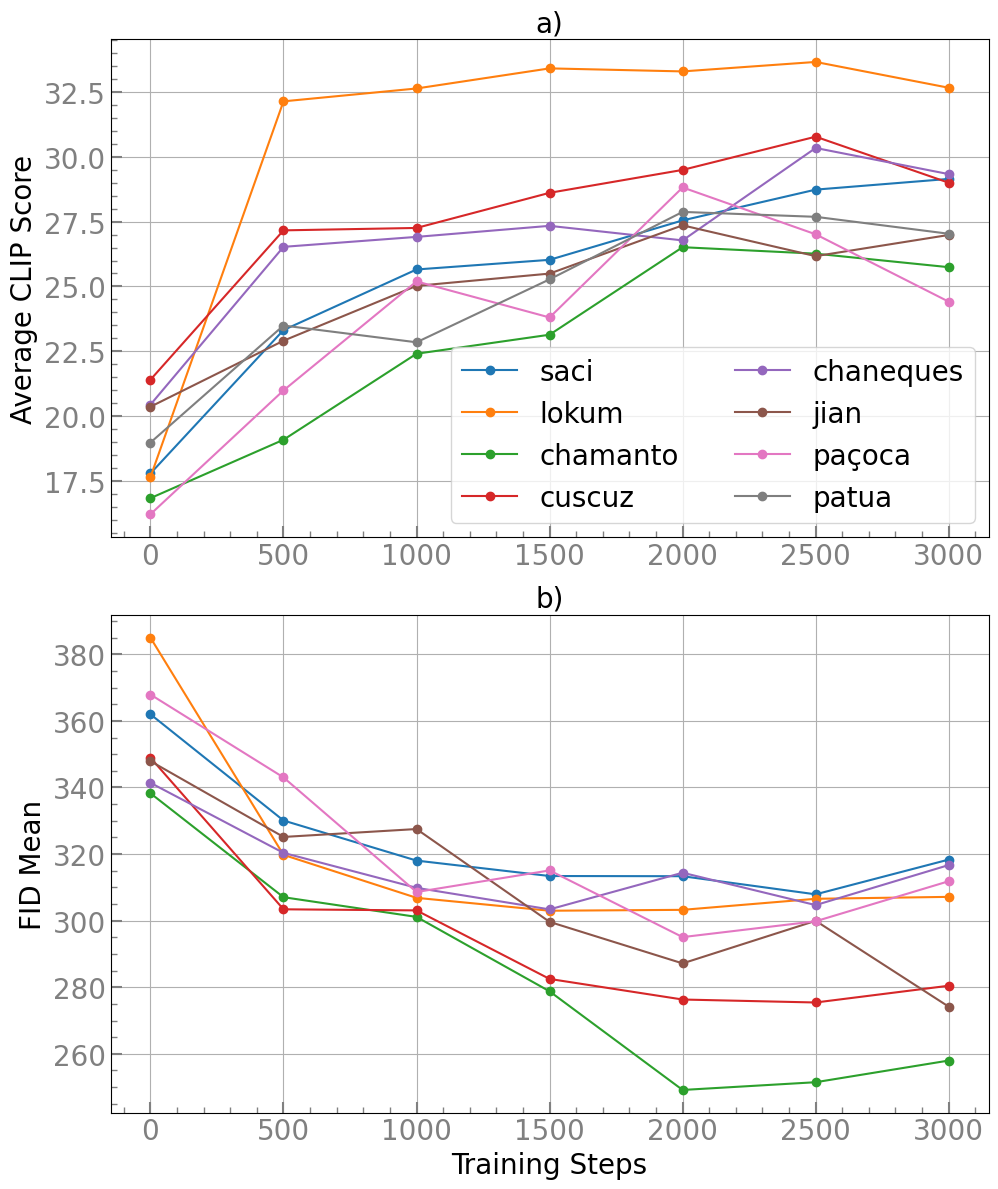

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados
clip_df = pd.read_csv("clip_score_checkpoints.csv")
fid_df = pd.read_csv("fid_scores_results_checkpoints.csv")

# Conceitos utilizados e valores iniciais (Checkpoint 0)
concepts = {
    "saci": {"clip": 17.80, "fid": 361.98},
    "lokum": {"clip": 17.66, "fid": 384.99},
    "chamanto": {"clip": 16.85, "fid": 338.25},
    "cuscuz": {"clip": 21.41, "fid": 348.93},
    "chaneques": {"clip": 20.45, "fid": 341.39},
    "jian": {"clip": 20.37, "fid": 347.90},
    "paçoca": {"clip": 16.23, "fid": 367.91},
    "patua": {"clip": 18.99, "fid": 378.74}
}

# Checkpoints a serem analisados (incluindo 0)
checkpoints = [0, 500, 1000, 1500, 2000, 2500, 3000]

# Criar a figura e subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Subplot 1 - CLIP Scores
for concept, values in concepts.items():
    concept_data = clip_df[clip_df["Folder"].str.contains(concept, case=False, na=False)]
    if not concept_data.empty:
        clip_scores = [values["clip"]] + concept_data["Average CLIP Score"].tolist()
        axes[0].plot(checkpoints, clip_scores, marker='o', label=concept)

axes[0].set_title("a)", fontsize=20, loc='center')
#axes[0].set_xlabel("Checkpoint", fontsize=16)
axes[0].set_ylabel("Average CLIP Score", fontsize=20)
axes[0].grid()
axes[0].minorticks_on()

# Subplot 2 - FID Scores
for concept, values in concepts.items():
    concept_data = fid_df[fid_df["Folder"].str.contains(concept, case=False, na=False)]
    if not concept_data.empty:
        fid_scores = [values["fid"]] + concept_data["FID Mean"].tolist()
        axes[1].plot(checkpoints, fid_scores, marker='o', label=concept)

axes[1].set_title("b)", fontsize=20, loc='center')
axes[1].set_xlabel("Training Steps", fontsize=20)
axes[1].set_ylabel("FID Mean", fontsize=20)
axes[1].grid()
axes[1].minorticks_on()

# Ajuste global de ticks e estilos
for ax in axes:
    ax.tick_params(axis='x', which='both', direction='in', length=8, width=1.5, colors='grey')
    ax.tick_params(axis='x', which='minor', direction='in', length=4, width=1.0, colors='grey')
    ax.tick_params(axis='y', which='both', direction='in', length=8, width=1.5, colors='grey')
    ax.tick_params(axis='y', which='minor', direction='in', length=4, width=1.0, colors='grey')
    ax.set_xticks(checkpoints)
    ax.tick_params(axis='both', labelsize=20)

# Definir a legenda no canto inferior direito, com duas colunas
axes[0].legend(fontsize=20, loc='lower right', ncol=2)

# Remover legenda do segundo subplot
#axes[1].get_legend().remove()

# Ajustar layout e mostrar
plt.tight_layout()
fig.savefig('fig_3_paper.pdf', bbox_inches='tight')

plt.show()



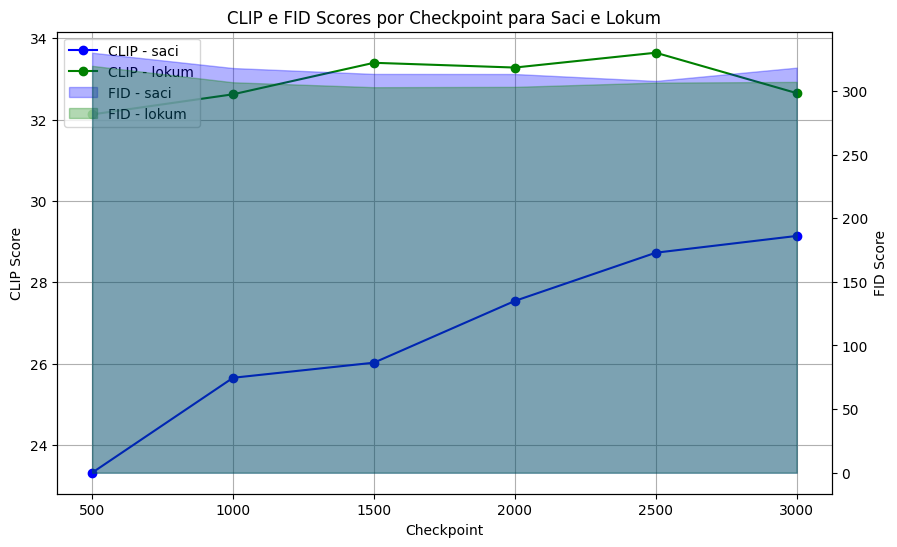

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Simulação dos dados (substitua pelo seu DataFrame real)
# merged_df = pd.read_csv("seu_arquivo.csv")

# Criar gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

concepts = merged_df["Concept"].unique()
colors = {"saci": "blue", "lokum": "green"}

ax2 = ax1.twinx()  # Criar segundo eixo Y

for concept in concepts:
    df_concept = merged_df[merged_df["Concept"] == concept]
    
    # Plotar CLIP Score como linha no eixo esquerdo
    ax1.plot(df_concept["Checkpoint"], df_concept["Average CLIP Score"], 
             marker='o', linestyle='-', color=colors[concept], label=f"CLIP - {concept}")
    
    # Preencher área para FID no eixo direito
    ax2.fill_between(df_concept["Checkpoint"], 0, # Preenchendo até o eixo x
                     df_concept["FID Mean"],
                     color=colors[concept], alpha=0.3, label=f"FID - {concept}")

# Configurações dos eixos
ax1.set_xlabel("Checkpoint")
ax1.set_ylabel("CLIP Score", color="black")
ax2.set_ylabel("FID Score", color="black")
ax1.set_title("CLIP e FID Scores por Checkpoint para Saci e Lokum")

# Combinar as legendas de ambos os eixos
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

ax1.grid(True)
plt.show()

In [10]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 388.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 486.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 397.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
